In [10]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import feather
from random import randint
from scipy.io import loadmat
import io


#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns

import xml.etree.ElementTree as ET


#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

# Create Dataframe from train_list

In [13]:
def init_df_from_mat_list(mat_file):
    mat = loadmat(mat_file)
    df = pd.DataFrame(columns=['id', 'image', 'annotation', 'breed', 'breed_label'])
    annotations =[]
    ids=[]
    for i in mat['annotation_list']:
        for j in i:
            for k in j:
                annotations.append('Annotation/'+k)
                ids.append(k.split('/')[-1])
    df['annotation'] = annotations
    df['id']=ids
    images = []
    breed_label=[]
    for i in mat['file_list']:
        for k in i:
                images.append('Images/'+k[0])
                breed_label.append(k[0].split('/')[0].split('-')[1])
    df['image'] = images
    df['breed_label'] = breed_label
    breed=[]
    for i in mat['labels']:
        for k in i:
                breed.append(k)
    df['breed'] = breed
    df.index=df.id
    return df

df_train = init_df_from_mat_list('train_list.mat')
df_test = init_df_from_mat_list('test_list.mat')
df= pd.concat([df_train,df_test])
print('dataset_size',df.shape[0])
print('train_size',df_train.shape[0])
print('test_size',df_test.shape[0])
print('Samples:')
df.sample(2)

dataset_size 20580
train_size 12000
test_size 8580
Samples:


,id,image,annotation,breed,breed_label
id,,,,,
n02095570_4854,n02095570_4854,Images/n02095570-Lakeland_terrier/n02095570_48...,Annotation/n02095570-Lakeland_terrier/n0209557...,39,Lakeland_terrier
n02105056_4846,n02105056_4846,Images/n02105056-groenendael/n02105056_4846.jpg,Annotation/n02105056-groenendael/n02105056_4846,74,groenendael


In [14]:
from bs4 import BeautifulSoup    

def apply_extract_annotations(x):
    file = open(x['annotation'])
    xml = file.read().strip()
    soup = BeautifulSoup(xml, 'xml')
    x['pose'] = soup.pose.get_text()
    x['width'] = soup.width.get_text()
    x['height'] = soup.height.get_text()
    #x['depth'] = soup.depth.get_text()
    #x['segment'] = soup.segment.get_text()
    #x['truncated'] = soup.truncated.get_text()
    #x['difficult'] = soup.difficult.get_text()
    x['box_xmin'] = soup.xmin.get_text()
    x['box_ymin'] = soup.ymin.get_text()
    x['box_xmax'] = soup.xmax.get_text()
    x['box_ymax'] = soup.ymax.get_text()
    return x

df = df.apply(apply_extract_annotations, axis=1)
df[['width', 'height', 'box_xmin', 'box_ymin', 'box_xmax', 'box_ymax']] = df[['width', 'height', 'box_xmin', 'box_ymin', 'box_xmax', 'box_ymax']].astype('int64')
#Note: very slow!

Always same value for : depth,segment,truncated,difficult
<br>Removing them.

In [17]:
df[['id', 'pose']].groupby('pose').count()

,id
pose,
NULL,624
Unspecified,19956


"pose" is useless also

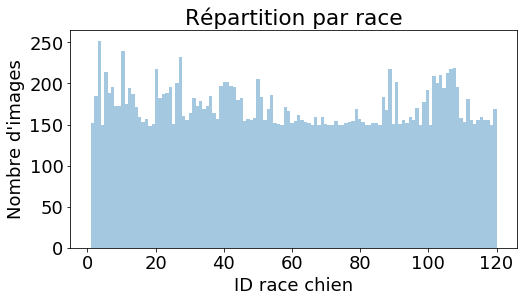

In [23]:
fig_size(8,4)
myplt = sns.distplot(df['breed'], bins=120, kde=False);
legend(myplt, 'Répartition par race', 'ID race chien', 'Nombre d\'images')


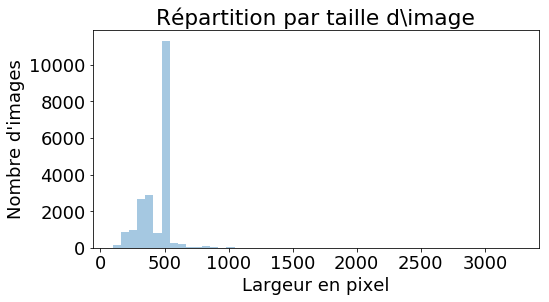

In [36]:
fig_size(8,4)
myplt = sns.distplot(df['width'], bins=50, kde=False);
legend(myplt, 'Répartition par taille d\image', 'Largeur en pixel', 'Nombre d\'images')


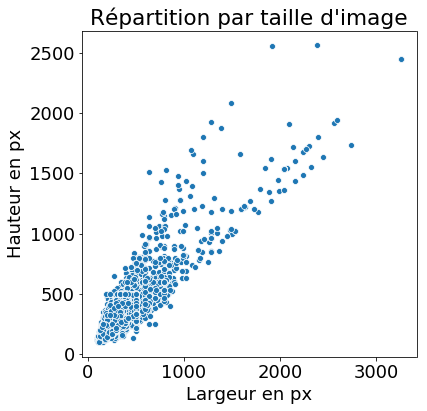

In [41]:
fig_size(6,6)

myplt=sns.scatterplot(x="width", y="height", data=df)
legend(myplt, 'Répartition par taille d\'image', 'Largeur en px', 'Hauteur en px')

In [24]:
df.describe(include='all')

,id,image,annotation,breed,breed_label,pose,width,height,box_xmin,box_ymin,box_xmax,box_ymax
count,20580,20580,20580,20580.000,20580,20580,20580.000,20580.000,20580.000,20580.000,20580.000,20580.000
unique,20580,20580,20580,nan,120,2,nan,nan,nan,nan,nan,nan
top,n02097130_3615,Images/n02109047-Great_Dane/n02109047_1284.jpg,Annotation/n02111129-Leonberg/n02111129_1503,nan,Maltese_dog,Unspecified,nan,nan,nan,nan,nan,nan
freq,1,1,1,nan,252,19956,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,59.526,NaN,NaN,442.532,385.861,76.541,56.541,365.582,354.171
std,NaN,NaN,NaN,35.169,NaN,NaN,142.792,124.863,75.279,59.406,129.140,122.409
min,NaN,NaN,NaN,1.000,NaN,NaN,97.000,100.000,0.000,0.000,71.000,90.000
25%,NaN,NaN,NaN,29.000,NaN,NaN,361.000,333.000,15.000,13.000,291.000,289.000
50%,NaN,NaN,NaN,58.000,NaN,NaN,500.000,375.000,57.000,39.000,359.000,339.000
75%,NaN,NaN,NaN,91.000,NaN,NaN,500.000,453.000,120.000,82.000,439.000,399.000


In [42]:
df.reset_index(drop=True).to_feather('df_raw1.feather')